**Step 1: Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, ConfusionMatrixDisplay

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings("ignore")

**Step 2: Load Dataset and Check Info.**

In [2]:
df = pd.read_csv("/kaggle/input/bank-marketing/bank-additional-full.csv", sep=';')
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [4]:
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

**Step 3: Exploratory Data Analysis (EDA)**

**Class Distribution**

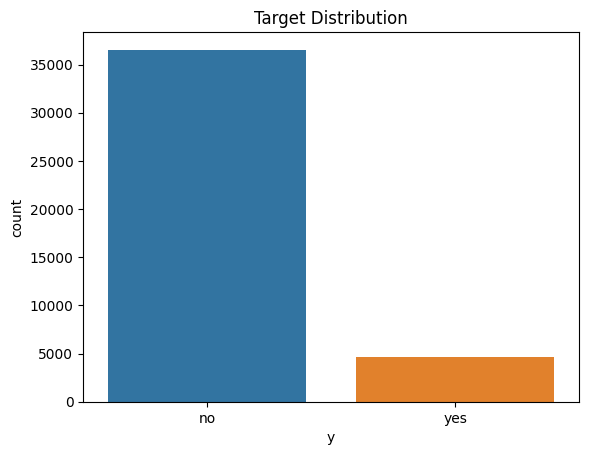

In [5]:
sns.countplot(x='y', data=df)
plt.title("Target Distribution")
plt.show()

**Correlation heatmap (numerical features only)**

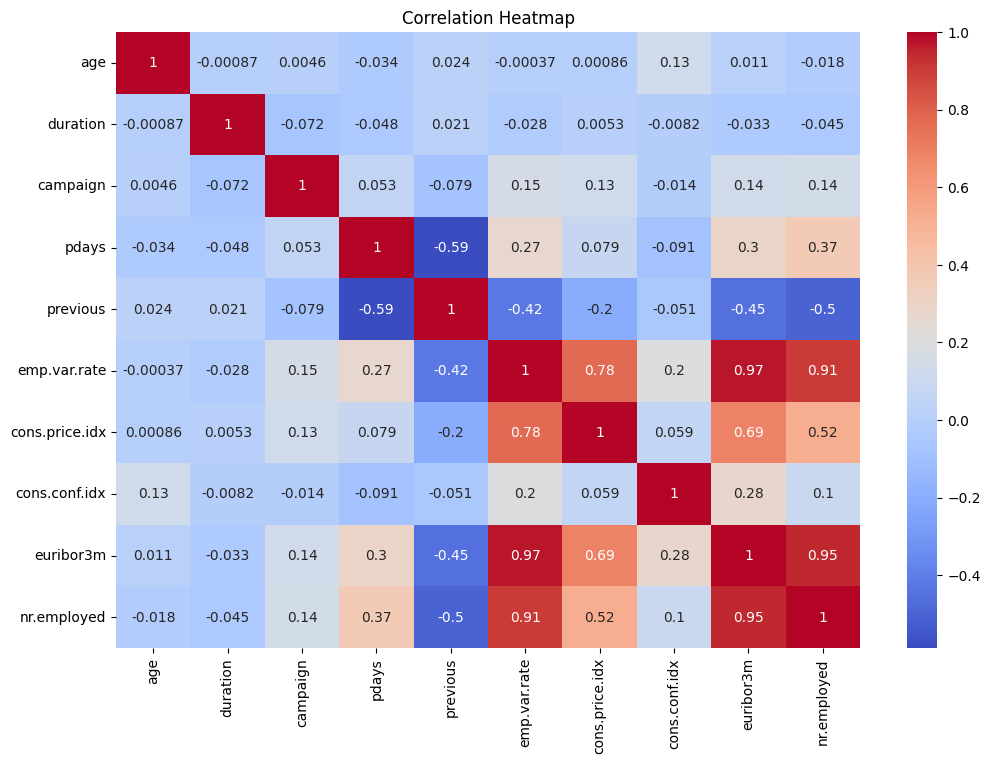

In [6]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=['int64', 'float64']).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

**Job distribution**

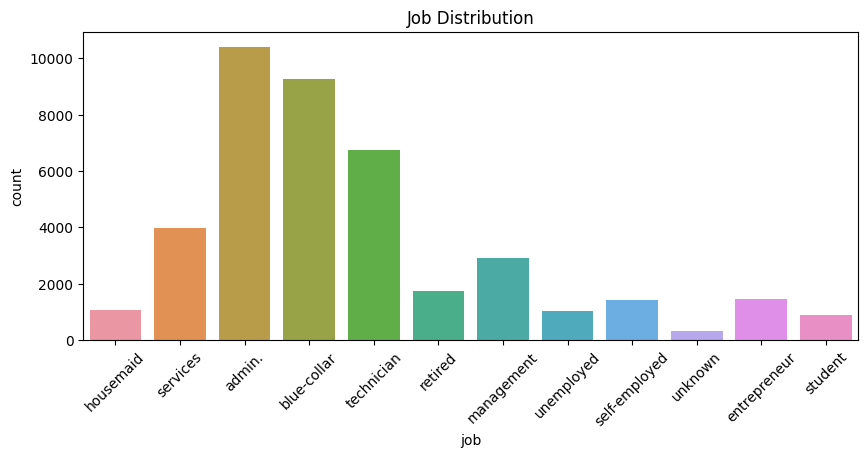

In [7]:
plt.figure(figsize=(10, 4))
sns.countplot(x='job', data=df)
plt.xticks(rotation=45)
plt.title("Job Distribution")
plt.show()

**Step 4: Data Preprocessing**

In [8]:
df = df.drop(columns=['duration'])

**Encode categorical**

In [9]:
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

**Feature Engineering**

In [10]:
df['age_bin'] = pd.cut(df['age'], bins=[17, 25, 40, 60, 100], labels=['Young', 'Adult', 'Middle', 'Senior'])
df['contact_success_ratio'] = df['previous'] / (df['campaign'] + 1)
df['was_contacted_before'] = (df['pdays'] != 999).astype(int)
df['financial_risk'] = df['housing'] + df['loan']

month_map = {
    0: 'Spring', 1: 'Summer', 2: 'Summer', 3: 'Fall',
    4: 'Fall', 5: 'Winter', 6: 'Winter', 7: 'Winter',
    8: 'Spring', 9: 'Spring', 10: 'Summer', 11: 'Fall'
}
df['season'] = df['month'].map(month_map)

**Encode new categorical**

In [11]:
for col in ['age_bin', 'season']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

**Step 5: Train-Test Split and Scaling**

In [12]:
X = df.drop("y", axis=1)
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Step 6: Define Models**

In [14]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    # "SVC": SVC(probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB()
}

**Train and Evaluation without Tuning**

In [15]:
results_untuned = {}
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    results_untuned[name] = {
        "model": model,
        "accuracy": acc,
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred),
        "fpr": roc_curve(y_test, y_proba)[0],
        "tpr": roc_curve(y_test, y_proba)[1],
        "roc_auc": auc(roc_curve(y_test, y_proba)[0], roc_curve(y_test, y_proba)[1]),
        "y_pred": y_pred
    }

    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name


In [16]:
print("Model Accuracy Scores (Untuned):")
for name, result in results_untuned.items():
    print(f"{name}: {result['accuracy']:.4f}")

print(f"\nBest Model: {best_model_name} with accuracy = {best_accuracy:.4f}")

Model Accuracy Scores (Untuned):
LogisticRegression: 0.9013
DecisionTree: 0.8446
RandomForest: 0.8986
GradientBoosting: 0.9020
AdaBoost: 0.9001
KNN: 0.8955
NaiveBayes: 0.8410

Best Model: GradientBoosting with accuracy = 0.9020


**Confusion Matrix and Classification Report for best untuned model**

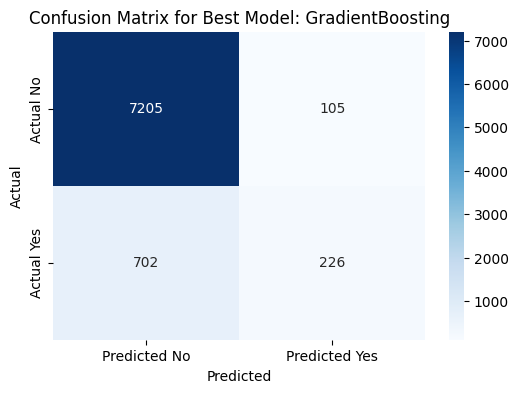


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.68      0.24      0.36       928

    accuracy                           0.90      8238
   macro avg       0.80      0.61      0.65      8238
weighted avg       0.89      0.90      0.88      8238



In [17]:
best_result = results_untuned[best_model_name]

conf_matrix = best_result['conf_matrix']

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title(f"Confusion Matrix for Best Model: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Best Model):")
print(best_result['report'])

**ROC Curves for all untuned models**

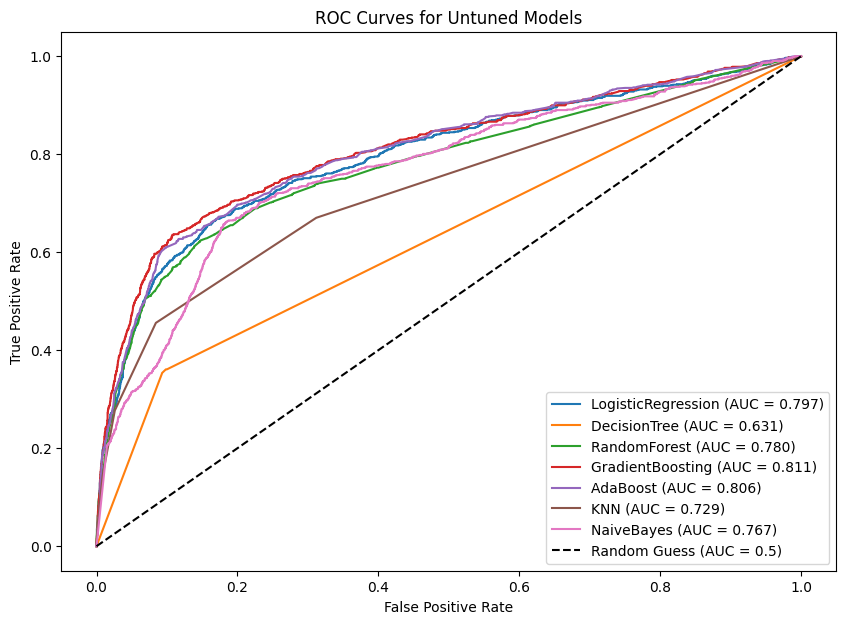

In [18]:
plt.figure(figsize=(10, 7))
for name, result in results_untuned.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{name} (AUC = {result['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.title("ROC Curves for Untuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()


**Step 7: Define Param Grids**

In [19]:
from sklearn.model_selection import GridSearchCV

param_grids = {
    "LogisticRegression": {'penalty': ['l2'], 'C': [0.01, 0.1, 1], 'solver': ['liblinear'], 'max_iter': [500]},
    "DecisionTree": {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    "RandomForest": {'n_estimators': [100, 200], 'max_depth': [None, 10], 'min_samples_split': [2], 'min_samples_leaf': [1]},
    "GradientBoosting": {'n_estimators': [100, 200], 'learning_rate': [0.1], 'max_depth': [3, 5]},
    "AdaBoost": {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]},
    # "SVC": {
    #     'C': [0.1, 1],
    #     'kernel': ['rbf', 'linear'],
    #     'gamma': ['scale']
    # },
    "KNN": {'n_neighbors': [3, 5], 'weights': ['uniform', 'distance']},
    "NaiveBayes": {'var_smoothing': [1e-09, 1e-08]}
}

**Train and Evaluation with Tuning**

In [20]:
results_tuned = {}
best_model_name = None
best_accuracy = 0

for name, model in models.items():
    grid = GridSearchCV(model, param_grids[name], cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train_scaled, y_train)

    best_model = grid.best_estimator_
    y_pred = best_model.predict(X_test_scaled)
    y_proba = best_model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)

    results_tuned[name] = {
        "model": best_model,
        "accuracy": acc,
        "conf_matrix": confusion_matrix(y_test, y_pred),
        "report": classification_report(y_test, y_pred),
        "fpr": roc_curve(y_test, y_proba)[0],
        "tpr": roc_curve(y_test, y_proba)[1],
        "roc_auc": auc(roc_curve(y_test, y_proba)[0], roc_curve(y_test, y_proba)[1]),
        "y_pred": y_pred,
        "y_proba": y_proba,
        "best_params": grid.best_params_
    }

    if acc > best_accuracy:
        best_accuracy = acc
        best_model_name = name


In [21]:
print("Model Accuracy Scores (Untuned):")
for name, result in results_tuned.items():
    print(f"{name}: {result['accuracy']:.4f}")

print(f"\nBest Model: {best_model_name} with accuracy = {best_accuracy:.4f}")

Model Accuracy Scores (Untuned):
LogisticRegression: 0.9018
DecisionTree: 0.8978
RandomForest: 0.9029
GradientBoosting: 0.9025
AdaBoost: 0.9007
KNN: 0.8955
NaiveBayes: 0.8410

Best Model: RandomForest with accuracy = 0.9029


**Confusion Matrix and Classification Report for best tuned model**

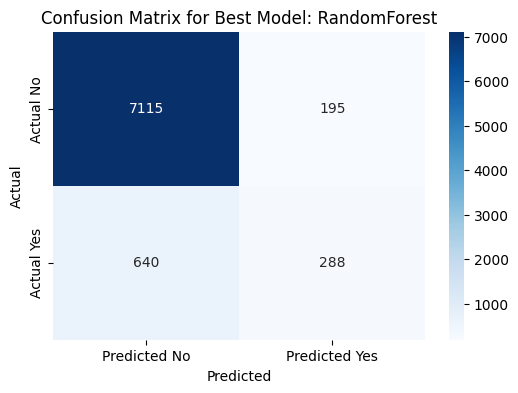


Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7310
           1       0.60      0.31      0.41       928

    accuracy                           0.90      8238
   macro avg       0.76      0.64      0.68      8238
weighted avg       0.88      0.90      0.88      8238



In [22]:
best_result = results_untuned[best_model_name]

conf_matrix = best_result['conf_matrix']

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.title(f"Confusion Matrix for Best Model: {best_model_name}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nClassification Report (Best Model):")
print(best_result['report'])

**ROC Curves for all tuned models**

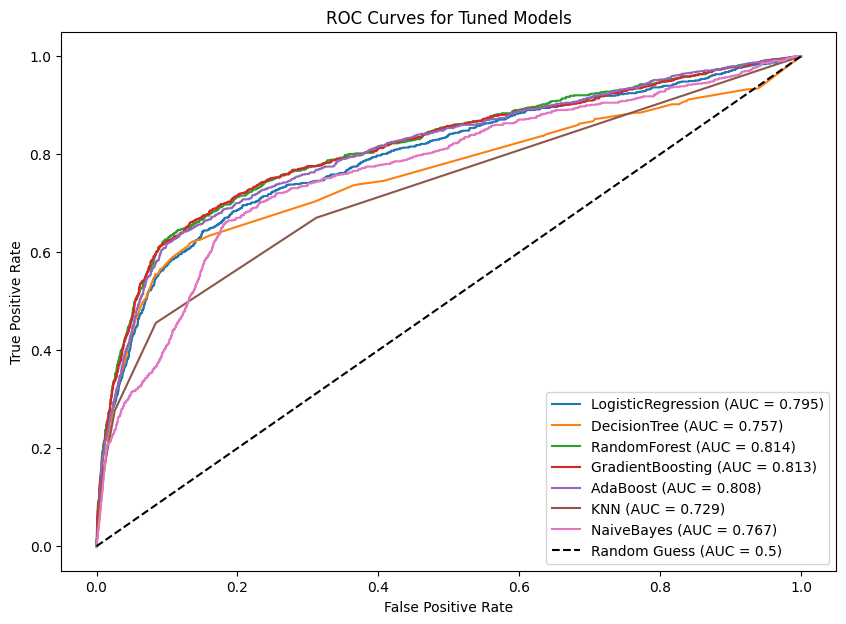

In [23]:
plt.figure(figsize=(10, 7))
for name, result in results_tuned.items():
    plt.plot(result["fpr"], result["tpr"], label=f"{name} (AUC = {result['roc_auc']:.3f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess (AUC = 0.5)')
plt.title("ROC Curves for Tuned Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

**Step 8: Model Comparison**

In [24]:
comparison_df = pd.DataFrame({
    "Model": list(models.keys()),
    "Accuracy (Untuned)": [results_untuned[m]["accuracy"] for m in models],
    "Accuracy (Tuned)": [results_tuned[m]["accuracy"] if m in results_tuned else None for m in models]
})
comparison_df = comparison_df.sort_values("Accuracy (Tuned)", ascending=False)
print("\nModel Accuracy Comparison (Untuned vs Tuned):")
print(comparison_df)


Model Accuracy Comparison (Untuned vs Tuned):
                Model  Accuracy (Untuned)  Accuracy (Tuned)
2        RandomForest            0.898640          0.902889
3    GradientBoosting            0.902039          0.902525
0  LogisticRegression            0.901311          0.901797
4            AdaBoost            0.900097          0.900704
1        DecisionTree            0.844622          0.897791
5                 KNN            0.895484          0.895484
6          NaiveBayes            0.840981          0.840981


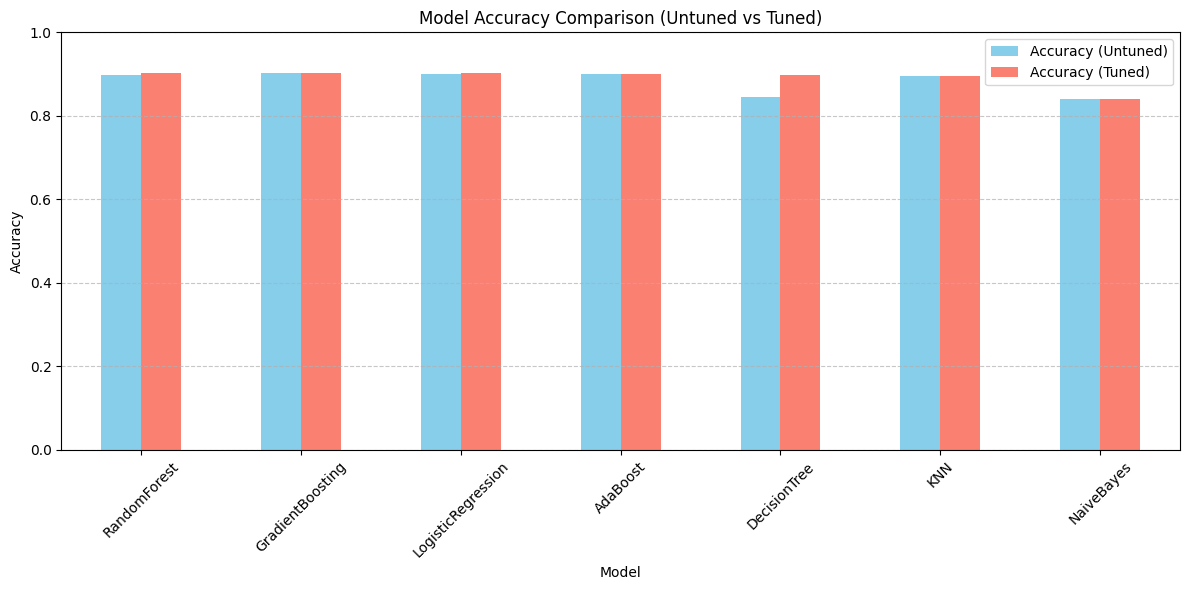

In [25]:
comparison_df.plot(
    x="Model",
    kind="bar",
    figsize=(12, 6),
    title="Model Accuracy Comparison (Untuned vs Tuned)",
    color=["skyblue", "salmon"]
)
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Step 9: Prediction**

In [26]:
comparison_preds = pd.DataFrame({
    "Actual": y_test.values,
    f"Untuned_{best_model_name}": results_untuned[best_model_name]['y_pred'],
    f"Tuned_{best_model_name}": results_tuned[best_model_name]['y_pred']
})

comparison_preds.head(10)

,Actual,Untuned_RandomForest,Tuned_RandomForest
0,0,0,0
1,0,0,0
2,0,1,1
3,0,0,0
4,0,0,0
5,0,0,0
6,0,0,0
7,0,0,0
8,1,1,1
9,0,0,0
